In [18]:
import torch
import torch.nn as nn
import numpy as np

# Set device to MPS if available (macOS GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Define the neural network
class FCNN(nn.Module):
    def __init__(self, layers):
        super(FCNN, self).__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

# Initial condition u(x,y,0) = sin(pi x) sin(pi y)
def initial_condition(x, y):
    return torch.sin(np.pi * x)# * torch.sin(np.pi * y)

# Heat equation PDE residual
def pde_residual(model, x, y, t, alpha):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)

    u = model(torch.cat([x, y, t], dim=1))

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    return u_t - alpha * (u_xx + u_yy)

# Training data
def generate_collocation_points(nf, ni, nb):
    # Collocation (interior) points
    x_f = torch.rand(nf, 1) * 2 - 1
    y_f = torch.rand(nf, 1) * 2 - 1
    t_f = torch.rand(nf, 1)

    # Initial condition points
    x_i = torch.rand(ni, 1) * 2 - 1
    y_i = torch.rand(ni, 1) * 2 - 1
    t_i = torch.zeros_like(x_i)

    # Boundary condition points
    t_b = torch.rand(nb, 1)
    zeros = torch.zeros(nb, 1)
    ones = torch.ones(nb, 1)

    xb = torch.cat([
        torch.rand(nb, 1) * 2 - 1,
        torch.rand(nb, 1) * 2 - 1,
        zeros, ones
    ], dim=0)
    yb = torch.cat([
        zeros,
        ones,
        torch.rand(nb, 1) * 2 - 1,
        torch.rand(nb, 1) * 2 - 1
    ], dim=0)
    tb = torch.cat([t_b]*4, dim=0)

    return x_f, y_f, t_f, x_i, y_i, t_i, xb, yb, tb

# Hyperparameters
alpha = 0.01
layers = [3, 50, 50, 50, 1]
model = FCNN(layers).to(device)

# Training points
nf, ni, nb = 10000, 1000, 1000
x_f, y_f, t_f, x_i, y_i, t_i, xb, yb, tb = generate_collocation_points(nf, ni, nb)

# Move to device
x_f, y_f, t_f = x_f.to(device), y_f.to(device), t_f.to(device)
x_i, y_i, t_i = x_i.to(device), y_i.to(device), t_i.to(device)
xb, yb, tb = xb.to(device), yb.to(device), tb.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE residual
    f_res = pde_residual(model, x_f, y_f, t_f, alpha)

    # Initial condition loss
    u_pred_i = model(torch.cat([x_i, y_i, t_i], dim=1))
    u_true_i = initial_condition(x_i, y_i).to(device)
    loss_i = torch.mean((u_pred_i - u_true_i)**2)

    # Boundary condition loss
    u_pred_b = model(torch.cat([xb, yb, tb], dim=1))
    loss_b = torch.mean(u_pred_b**2)

    # PDE loss
    loss_f = torch.mean(f_res**2)

    # Total loss
    loss = loss_i + loss_b + loss_f

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}|"
        f"PDE = {loss_f.item():.2e} | IC = {loss_i.item():.2e} |"
              f"BC = {loss_b.item():.2e}")

Epoch 0: Loss = 5.92650e-01|PDE = 2.16e-03 | IC = 5.74e-01 |BC = 1.66e-02
Epoch 500: Loss = 1.17387e-01|PDE = 1.03e-02 | IC = 3.68e-02 |BC = 7.03e-02
Epoch 1000: Loss = 6.75458e-02|PDE = 6.73e-03 | IC = 3.24e-02 |BC = 2.84e-02
Epoch 1500: Loss = 6.42496e-02|PDE = 6.42e-03 | IC = 3.19e-02 |BC = 2.59e-02
Epoch 2000: Loss = 6.19878e-02|PDE = 6.62e-03 | IC = 3.13e-02 |BC = 2.41e-02
Epoch 2500: Loss = 5.92200e-02|PDE = 6.81e-03 | IC = 3.04e-02 |BC = 2.20e-02
Epoch 3000: Loss = 5.61252e-02|PDE = 7.30e-03 | IC = 2.87e-02 |BC = 2.02e-02
Epoch 3500: Loss = 5.24603e-02|PDE = 7.90e-03 | IC = 2.61e-02 |BC = 1.84e-02
Epoch 4000: Loss = 4.89350e-02|PDE = 8.38e-03 | IC = 2.35e-02 |BC = 1.71e-02
Epoch 4500: Loss = 4.89103e-02|PDE = 8.57e-03 | IC = 2.50e-02 |BC = 1.53e-02


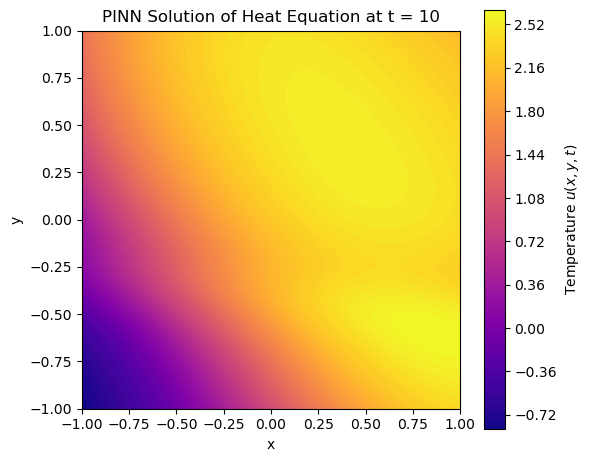

In [21]:
import matplotlib.pyplot as plt

def plot_solution(model, t_val=0.5, resolution=100):
    """
    Plot u(x, y, t=t_val) over the 2D spatial domain [-1, 1] x [-1, 1].
    """
    model.eval()
    x = np.linspace(-1, 1, resolution)
    y = np.linspace(-1, 1, resolution)
    X, Y = np.meshgrid(x, y)
    XT = torch.tensor(X.reshape(-1, 1), dtype=torch.float32).to(device)
    YT = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32).to(device)
    TT = torch.full_like(XT, t_val)

    with torch.no_grad():
        U_pred = model(torch.cat([XT, YT, TT], dim=1)).cpu().numpy().reshape(resolution, resolution)

    plt.figure(figsize=(6, 5))
    cp = plt.contourf(X, Y, U_pred, 100, cmap='plasma')
    plt.colorbar(cp, label="Temperature $u(x,y,t)$")
    plt.title(f"PINN Solution of Heat Equation at t = {t_val}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('square')
    plt.tight_layout()
    plt.show()

# Example usage after training
plot_solution(model, t_val=10)